Phase 6 _ Hyperparameter Tuning.

In [13]:
#  mount drive and import libraries
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import time
import joblib
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
#  load train and test data from Drive
train_path = "/content/drive/MyDrive/train.csv"
test_path  = "/content/drive/MyDrive/test.csv"

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

X_train, y_train = train.drop(columns=["target"]), train["target"]
X_test,  y_test  = test.drop(columns=["target"]),  test["target"]

print("Train shape:", train.shape)
print("Test shape: ", test.shape)
print("Target classes:", sorted(y_train.unique()))


Train shape: (242, 16)
Test shape:  (61, 16)
Target classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


In [15]:
#  define models and parameter distributions
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier()
}

param_dists = {
    "Logistic Regression": {
        "C": np.logspace(-2, 2, 10),
        "penalty": ["l2"],
        "solver": ["lbfgs"]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 5, 10, 20],
        "min_samples_split": [2, 5, 10]
    },
    "SVM": {
        "C": np.logspace(-2, 2, 8),
        "kernel": ["linear", "rbf"],
        "gamma": ["scale", "auto"]
    },
    "KNN": {
        "n_neighbors": list(range(3, 11)),
        "weights": ["uniform", "distance"]
    }
}


In [16]:
#  run RandomizedSearchCV for each model, evaluate and save best model
results = []
n_iter = 10

for name, model in models.items():
    print(f"\nTuning {name} ...")
    dist = param_dists[name]
    try:
        rs = RandomizedSearchCV(
            model,
            param_distributions=dist,
            n_iter=n_iter,
            cv=5,
            scoring="accuracy",
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        t0 = time.time()
        rs.fit(X_train, y_train)
        elapsed = time.time() - t0
        best = rs.best_estimator_
        best_params = rs.best_params_
        print(f" Done in {elapsed:.1f}s - best params: {best_params}")
    except Exception as e:
        print("RandomizedSearchCV failed or timed out:", e)
        print("Falling back to training the default model and continuing.")
        t0 = time.time()
        model.fit(X_train, y_train)
        elapsed = time.time() - t0
        best = model
        best_params = "default_fit"

    # Evaluate on test set
    y_pred = best.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f" Test Accuracy for {name}: {acc:.4f}")

    # Save best model to Drive
    safe_name = name.lower().replace(" ", "")
    save_path = f"/content/drive/MyDrive/models/{safe_name}_best.pkl"
    joblib.dump(best, save_path)
    print(f" Saved: {save_path}")

    results.append({"Model": name, "Best Params": best_params, "Test Accuracy": acc})



Tuning Logistic Regression ...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
 Done in 0.7s - best params: {'solver': 'lbfgs', 'penalty': 'l2', 'C': np.float64(0.5994842503189409)}
 Test Accuracy for Logistic Regression: 0.5902
 Saved: /content/drive/MyDrive/models/logisticregression_best.pkl

Tuning Random Forest ...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
 Done in 12.1s - best params: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 5}
 Test Accuracy for Random Forest: 0.5246
 Saved: /content/drive/MyDrive/models/randomforest_best.pkl

Tuning SVM ...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
 Done in 4.0s - best params: {'kernel': 'linear', 'gamma': 'scale', 'C': np.float64(0.517947467923121)}
 Test Accuracy for SVM: 0.5902
 Saved: /content/drive/MyDrive/models/svm_best.pkl

Tuning KNN ...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
 Done in 0.3s - best params: {'weights': 'uniform', 'n_neighbors': 10}


Saved results CSV: /content/drive/MyDrive/Heart_Disease_Project/data/hyperparam_results.csv


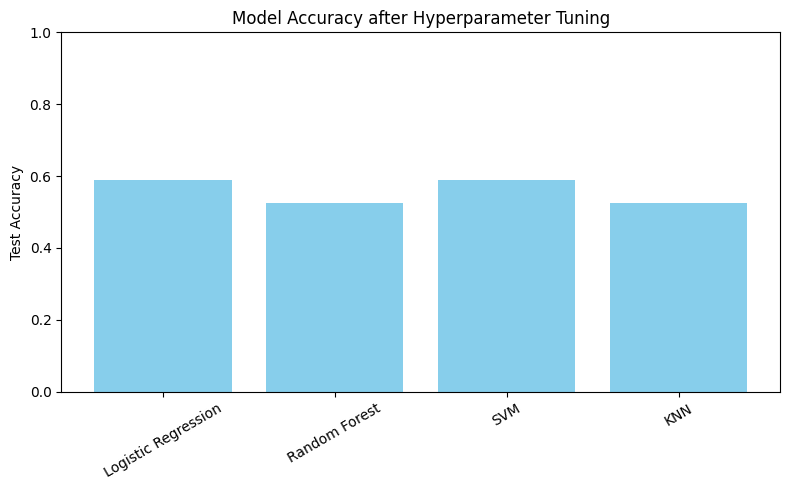

Saved plot: /content/drive/MyDrive/phase6_accuracy_plot.png


In [17]:
#  save results and plot comparison
results_df = pd.DataFrame(results)
results_csv_path = "/content/drive/MyDrive/Heart_Disease_Project/data/hyperparam_results.csv"
results_df.to_csv(results_csv_path, index=False)
print("Saved results CSV:", results_csv_path)

# Plot comparison
plt.figure(figsize=(8,5))
plt.bar(results_df["Model"], results_df["Test Accuracy"], color="skyblue")
plt.ylim(0,1)
plt.ylabel("Test Accuracy")
plt.title("Model Accuracy after Hyperparameter Tuning")
plt.xticks(rotation=30)
plot_path = "/content/drive/MyDrive/phase6_accuracy_plot.png"
plt.tight_layout()
plt.savefig(plot_path)
plt.show()
print("Saved plot:", plot_path)
